# 1. 데이터(축구평점)

In [159]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/data_football_ratings.csv')

ai = (df['is_human'] == 0)
df_ai = df[ai]
df.drop(index = df_ai.index, axis = 0, inplace = True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
df_ai.shape, df.shape

((23756, 63), (26896, 63))

,is_human,original_rating,goals,assists,shots_ontarget,shots_offtarget,shotsblocked,chances2score,drib_success,drib_unsuccess,...,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,win,lost,is_home_team,minutesPlayed,game_duration
pos,,,,,,,,,,,,,,,,,,,,,
DF,1.0,4.667744,0.038902,0.037805,0.124390,0.301341,0.091585,0.280854,0.356707,0.181707,...,0.191705,0.672214,0.396731,1.006027,0.005410,0.371585,0.367805,0.416098,88.127561,90.373171
FW,1.0,4.616627,0.322658,0.107019,0.813184,1.139845,0.419002,1.362423,0.821457,0.666400,...,0.160242,0.679325,0.264984,1.003339,0.024845,0.393915,0.357086,0.427809,82.030958,90.320256
GK,1.0,4.377193,0.000000,0.000900,0.000000,0.003599,0.000900,0.004498,0.004948,0.001350,...,0.088380,0.564751,0.227804,0.000000,0.001316,0.372919,0.367521,0.419703,90.000000,90.377868
MF,1.0,4.689940,0.106205,0.091061,0.358246,0.754155,0.308880,0.714033,0.749828,0.499459,...,0.199592,0.707377,0.366421,1.002394,0.011819,0.362769,0.374275,0.417642,83.049071,90.404170
Sub,1.0,5.329879,0.071568,0.031287,0.221744,0.354713,0.149003,0.376613,0.342589,0.234259,...,0.101850,0.566807,0.121233,0.141109,0.017210,0.330856,0.420806,0.394603,38.582323,90.727415


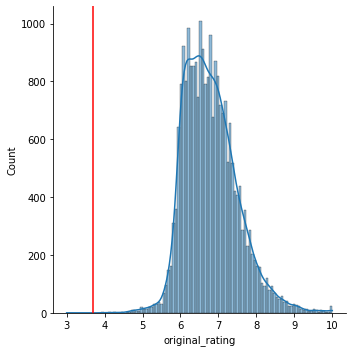

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df_ai['original_rating'],kde=True);
plt.axvline(3.7, color='red');

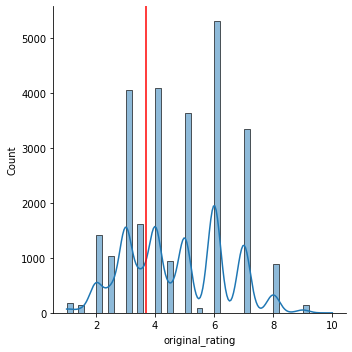

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df['original_rating'],kde=True);
plt.axvline(3.7, color='red');

#2. Feature engineering

In [163]:
def engineer(df):
  

  df['original_rating'] = df['original_rating'].apply(lambda x : int(x))

  # 평점사 및 포지션 GK 제거
  con_rater = (df['rater'] == 'Kicker') | (df['rater']== 'Bild') | (df['pos']=='GK')
  df.drop(index = df[con_rater].index, axis = 0,inplace = True)
  
  #타겟 만들기
  bins = [0,6,8,11]
  labels = ['★','★★','★★★']
  df['Grade'] = pd.cut(df['original_rating'], bins, right=False, labels=labels)

  #특성추가
  df['pass_acc'] = df['passes_acc']/ (df['passes_acc']+df['passes_inacc'])
  df['cross_acc'] = df['crosses_acc']/ (df['crosses_acc']+df['crosses_inacc'])
 
  #결측치 0으로 처리
  df['cross_acc'] = df['cross_acc'].fillna(0)
  df['pass_acc'] = df['pass_acc'].fillna(0)

  # 특성 제거(골키퍼, 매치데이터, 팀)
  df.drop(['goals_ag_otb','goals_ag_itb', 'saves_itb', 'saves_otb', 'saved_pen',
           'competition','date','match', 'player','team','is_home_team', 'pos',
           'minutesPlayed','game_duration','is_human','rater','win','lost'
           , 'pos_role','original_rating'], axis = 1,inplace = True)

  return df


In [164]:
#적용
df = engineer(df)
df_ai = engineer(df_ai)

In [ ]:
#결측치 확인, 범주값 확인
df.isnull().sum(), df.nunique()

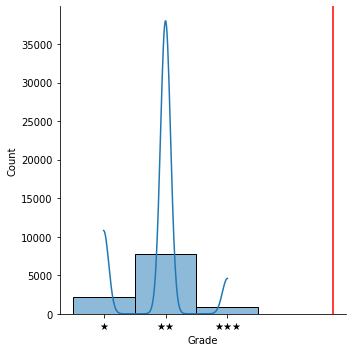

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df['Grade'],kde=True);
plt.axvline(3.7, color='red');

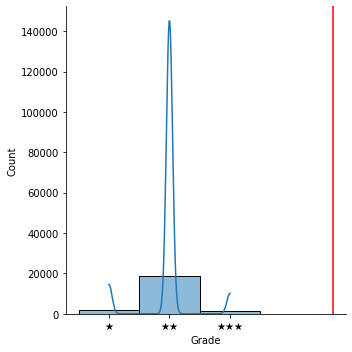

In [85]:
sns.displot(df_ai['Grade'],kde=True);
plt.axvline(3.7, color='red');

In [86]:
from sklearn.model_selection import train_test_split

#타겟, 피쳐 나누기
def split(df):
  #타겟
  target = 'Grade'
  
  y = df[target]
  X = df.drop(target , axis = 1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 3)

  return X_train, X_test, y_train, y_test


In [165]:
#split 적용
X_train, X_test, y_train, y_test = split(df)
X_train_ai, X_test_ai, y_train_ai, y_test_ai = split(df_ai)

In [88]:
X_train.shape, X_test.shape

((8742, 45), (2186, 45))

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

#기준 모델(최빈값)
y_pred = [y_train.mode()[0]] * len(y_train)
Accuracy = accuracy_score(y_train, y_pred)
print('Accuracy_score : ' , Accuracy)


Accuracy_score :  0.7105925417524593


In [130]:
#기준 모델(최빈값)
y_pred_ai = [y_train_ai.mode()[0]] * len(y_train_ai)
Accuracy1 = accuracy_score(y_train_ai, y_pred_ai)

print('기준모델_최빈값')
print('hu_Accuracy_score : ' , Accuracy)
print('ai_Accuracy_score : ' , Accuracy1)


기준모델_최빈값
hu_Accuracy_score :  0.7105925417524593
ai_Accuracy_score :  0.8561265721928177


In [91]:
!pip install category_encoders

# 랜덤포레스트

In [131]:
#분류모델(boosting)
from category_encoders import OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

#랜덤포레스트 모델
pipe = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
    RandomForestClassifier(
        random_state=2,
        n_jobs=-1
                 )
    #RandomForestClassifier(random_state=2, n_jobs=-1),
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2))])

In [132]:
pipe1 = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
    RandomForestClassifier(
        random_state=2,
        n_jobs=-1
                 )
    #RandomForestClassifier(random_state=2, n_jobs=-1),
)

pipe1.fit(X_train_ai, y_train_ai)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2))])

In [133]:
#스토어 확인 (과적합 발견)
pipe.score(X_train, y_train)

1.0

In [134]:
pipe1.score(X_train_ai, y_train_ai)

0.9922599738204997

In [135]:
#randomiaedsearch 진행

#하이퍼 파라미터 설정
dists = {
    'randomforestclassifier__n_estimators': [1000], 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__min_samples_leaf': [5, 10, 15, 20, 30],
    'randomforestclassifier__class_weight' : ['balanced',None]
    #'randomforestclassifier__min_samples_split': [5, 10, 15, 20, 30] 
}

#진행
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

#학습
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(cols=[],
                                                            use_cat_names=True)),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=2))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__class_weight': ['balanced',
                                                                                 None],
                                        'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                 

In [137]:
clf_ai = RandomizedSearchCV(
    pipe1, 
    param_distributions=dists, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

#학습
clf_ai.fit(X_train_ai, y_train_ai)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(cols=[],
                                                            use_cat_names=True)),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=2))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__class_weight': ['balanced',
                                                                                 None],
                                        'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                 

In [138]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('Accuracy: ', clf.best_score_)

print('AI최적 하이퍼파라미터: ', clf_ai.best_params_)
print('AI_Accuracy: ', clf_ai.best_score_)


최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__class_weight': None}
Accuracy:  0.7218025861132809
AI최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__class_weight': None}
AI_Accuracy:  0.8751920341394026


In [140]:
from sklearn.metrics import classification_report
pred = clf.predict(X_test)
print('randomforest')
print(classification_report(y_test, pred))
pred_ai = clf_ai.predict(X_test_ai)
print(classification_report(y_test_ai, pred_ai))
print('결과 : 기준모델보다 성능이 오른것을 확인할 수 있지만 크게 오르지 않음.')

randomforest
              precision    recall  f1-score   support

           ★       0.00      0.00      0.00       431
          ★★       0.73      1.00      0.84      1568
         ★★★       0.90      0.20      0.32       187

    accuracy                           0.73      2186
   macro avg       0.54      0.40      0.39      2186
weighted avg       0.60      0.73      0.63      2186

              precision    recall  f1-score   support

           ★       0.85      0.04      0.08       397
          ★★       0.87      0.99      0.93      3738
         ★★★       0.85      0.38      0.53       258

    accuracy                           0.87      4393
   macro avg       0.86      0.47      0.51      4393
weighted avg       0.87      0.87      0.83      4393

결과 : 기준모델보다 성능이 오른것을 확인할 수 있지만 크게 오르지 않음.


In [ ]:
# 특성 중요도
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values(ascending = False)

flow_centrality           0.059912
betweenness_centrality    0.055617
flow_success              0.051059
touches                   0.050427
pass_acc                  0.046881
closeness_centrality      0.044961
degree_centrality         0.043448
passes_acc                0.042843
poss_lost                 0.035856
grduels_l                 0.031092
grduels_w                 0.030672
goals                     0.030373
passes_inacc              0.027648
interceptions             0.024942
betweenness2goals         0.024687
aerials_l                 0.024454
lballs_acc                0.024234
aerials_w                 0.024206
clearances                0.022187
lballs_inacc              0.020514
countattack               0.020283
tackles                   0.019039
crosses_inacc             0.018624
wasfouled                 0.018368
fouls                     0.018056
shots_ontarget            0.015698
dribbled_past             0.014924
drib_success              0.014010
chances2score       

In [ ]:
rf1 = pipe1.named_steps['randomforestclassifier']
importances = pd.Series(rf1.feature_importances_, X_train_ai.columns)
importances.sort_values(ascending = False)

goals                     0.064237
flow_centrality           0.060230
touches                   0.057083
betweenness_centrality    0.050519
flow_success              0.047987
closeness_centrality      0.043083
degree_centrality         0.042987
passes_acc                0.041429
pass_acc                  0.038894
betweenness2goals         0.034442
poss_lost                 0.033356
grduels_w                 0.029945
grduels_l                 0.028397
aerials_w                 0.027484
shots_ontarget            0.026210
passes_inacc              0.024810
aerials_l                 0.022809
interceptions             0.020841
lballs_acc                0.020749
clearances                0.018385
fouls                     0.018006
lballs_inacc              0.017585
tackles                   0.016698
drib_success              0.015794
countattack               0.015237
wasfouled                 0.015215
crosses_inacc             0.015039
assists                   0.014541
chances2score       

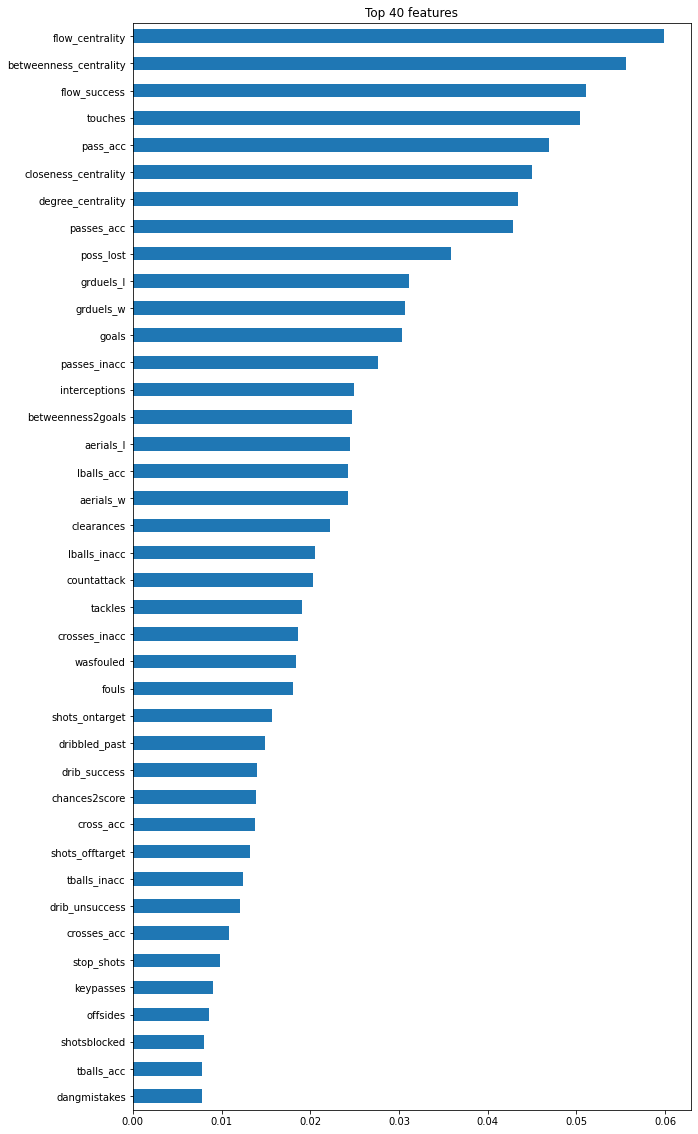

In [ ]:
# 특성 중요도 시각화
end = pipe.named_steps['onehotencoder']
X_train_encoded = end.fit_transform(X_train)
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train_encoded.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 40
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

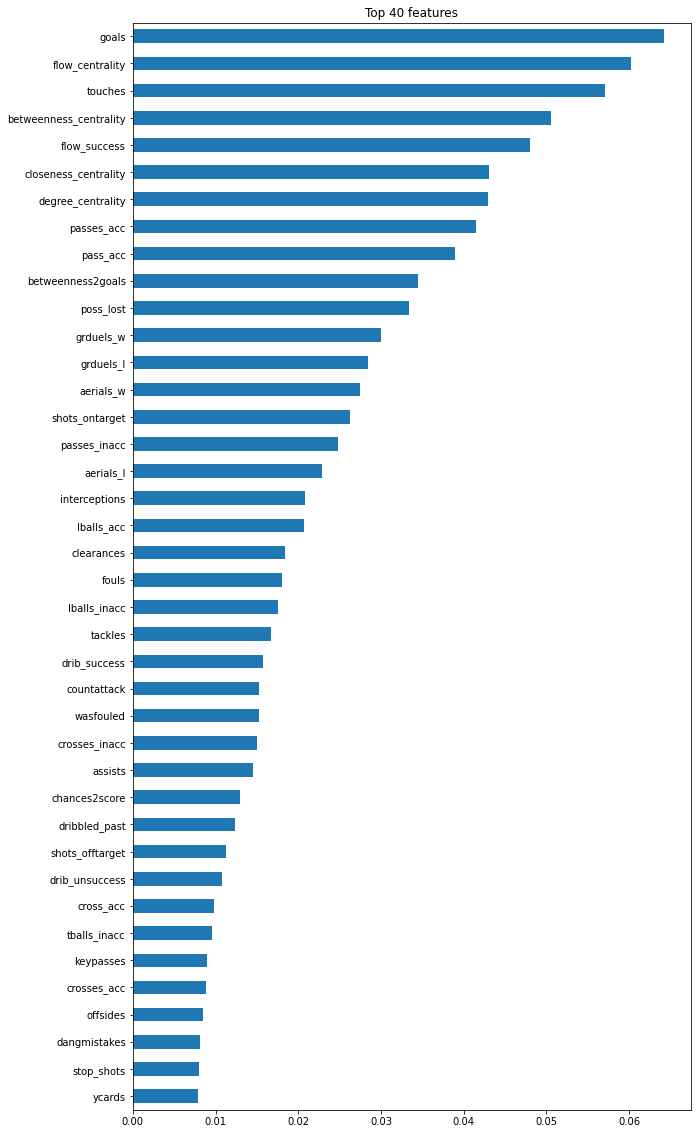

In [ ]:
end = pipe1.named_steps['onehotencoder']
X_train_encoded_ai = end.fit_transform(X_train_ai)
rf = pipe1.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train_encoded_ai.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 40
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

#XGBOOST

In [92]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_test_encoded = encoder.transform(X_test) # 검증데이터

encoder1 = OrdinalEncoder()
X_train_encoded_ai = encoder1.fit_transform(X_train_ai)
X_test_encoded_ai = encoder1.transform(X_test_ai)

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=5,        # .
    learning_rate=0.2,
    #scale_pos_weight = 'ratio', # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='merror', # #(wrong cases)/#(all cases)
          early_stopping_rounds = 50)

[0]	validation_0-merror:0.268817	validation_1-merror:0.268527
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.268817	validation_1-merror:0.266697
[2]	validation_0-merror:0.270304	validation_1-merror:0.264867
[3]	validation_0-merror:0.270876	validation_1-merror:0.263952
[4]	validation_0-merror:0.267788	validation_1-merror:0.26624
[5]	validation_0-merror:0.268245	validation_1-merror:0.26441
[6]	validation_0-merror:0.268932	validation_1-merror:0.264867
[7]	validation_0-merror:0.267902	validation_1-merror:0.263495
[8]	validation_0-merror:0.267445	validation_1-merror:0.263952
[9]	validation_0-merror:0.265157	validation_1-merror:0.26441
[10]	validation_0-merror:0.264242	validation_1-merror:0.26441
[11]	validation_0-merror:0.262869	validation_1-merror:0.265325
[12]	validation_0-merror:0.262411	validation_1-merror:0.263952
[13]	validation_0-merror:0.26172

XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=1000, n_jobs=-1,
              objective='multi:softprob')

In [93]:
encoder1 = OrdinalEncoder()
X_train_encoded_ai = encoder1.fit_transform(X_train_ai)
X_test_encoded_ai = encoder1.transform(X_test_ai)

model_ai = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=5,        # .
    learning_rate=0.2,
    #scale_pos_weight = 'ratio', # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set_ai = [(X_train_encoded_ai, y_train_ai), 
            (X_test_encoded_ai, y_test_ai)]

model_ai.fit(X_train_encoded_ai, y_train_ai, 
          eval_set=eval_set_ai,
          eval_metric='merror', # #(wrong cases)/#(all cases)
          early_stopping_rounds = 50)

[0]	validation_0-merror:0.122702	validation_1-merror:0.132711
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.122418	validation_1-merror:0.130207
[2]	validation_0-merror:0.121678	validation_1-merror:0.131345
[3]	validation_0-merror:0.120995	validation_1-merror:0.129069
[4]	validation_0-merror:0.121621	validation_1-merror:0.130435
[5]	validation_0-merror:0.120596	validation_1-merror:0.129752
[6]	validation_0-merror:0.120596	validation_1-merror:0.130435
[7]	validation_0-merror:0.120198	validation_1-merror:0.128841
[8]	validation_0-merror:0.119857	validation_1-merror:0.129069
[9]	validation_0-merror:0.119401	validation_1-merror:0.127476
[10]	validation_0-merror:0.118605	validation_1-merror:0.127248
[11]	validation_0-merror:0.118434	validation_1-merror:0.127476
[12]	validation_0-merror:0.117808	validation_1-merror:0.12702
[13]	validation_0-merror:0.11

XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=1000, n_jobs=-1,
              objective='multi:softprob')

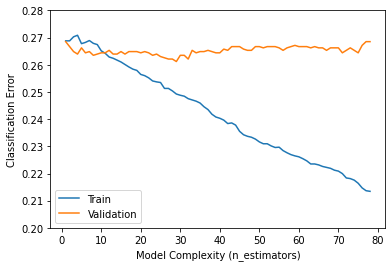

In [94]:
results = model.evals_result()
train_error = results['validation_0']['merror']
test_error = results['validation_1']['merror']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, test_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.2, 0.28)) # Zoom in
plt.legend();

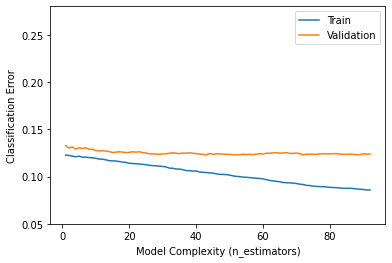

In [95]:
results = model_ai.evals_result()
train_error = results['validation_0']['merror']
test_error = results['validation_1']['merror']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, test_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.05, 0.28)) # Zoom in
plt.legend();

In [96]:
from sklearn.metrics import classification_report

print('검증 정확도', model.score(X_train_encoded, y_train))
print('검증 정확도', model.score(X_test_encoded, y_test))

print(classification_report(y_test, model.predict(X_test_encoded)))

print('검증 정확도', model.score(X_train_encoded_ai, y_train_ai))
print('검증 정확도', model_ai.score(X_test_encoded_ai, y_test_ai))

print(classification_report(y_test_ai, model_ai.predict(X_test_encoded_ai)))


print('랜덤포레스트 모델보다 검증 정확도 증가.')

검증 정확도 0.7507435369480668
검증 정확도 0.7387923147301007
              precision    recall  f1-score   support

           ★       0.54      0.03      0.06       431
          ★★       0.74      0.98      0.84      1568
         ★★★       0.81      0.30      0.44       187

    accuracy                           0.74      2186
   macro avg       0.70      0.44      0.45      2186
weighted avg       0.71      0.74      0.66      2186

검증 정확도 0.8701838256217631
검증 정확도 0.8770771682221716
              precision    recall  f1-score   support

           ★       0.72      0.07      0.13       397
          ★★       0.88      0.99      0.93      3738
         ★★★       0.81      0.50      0.62       258

    accuracy                           0.88      4393
   macro avg       0.80      0.52      0.56      4393
weighted avg       0.86      0.88      0.84      4393

랜덤포레스트 모델보다 검증 정확도 증가.


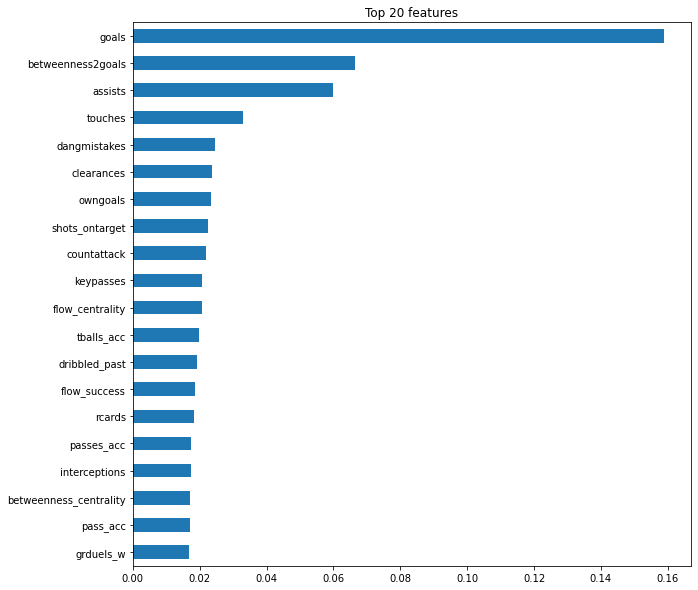

In [103]:
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')


importances = pd.Series(model.feature_importances_, X_train_encoded.columns)
importances.sort_values(ascending = True)[-n:].plot.barh();

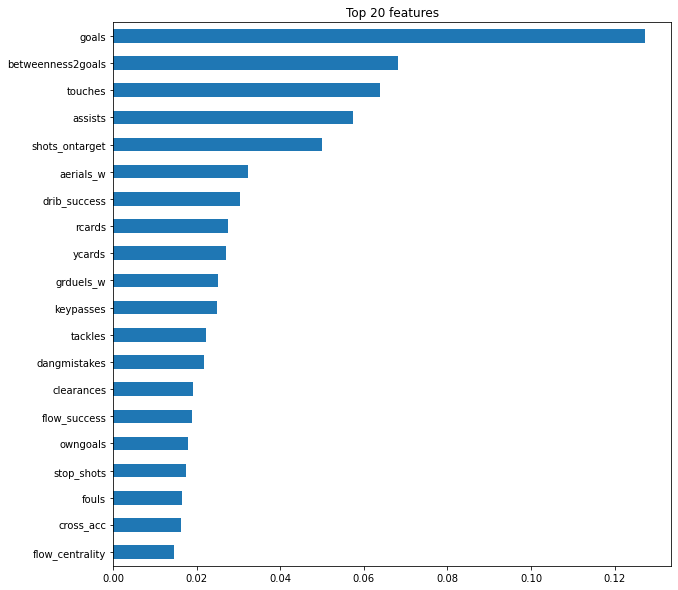

In [104]:
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')

importances_ai = pd.Series(model_ai.feature_importances_, X_train_encoded_ai.columns)
importances_ai.sort_values(ascending = True)[-n:].plot.barh();

In [29]:
!pip install eli5

     |████████████████████████████████| 106 kB 24.1 MB/s 


#Permutation

In [105]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

In [106]:
# permuter 정의
permuter = PermutationImportance(
    model, # model
    scoring='accuracy', # metric
    n_iter=10, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)


# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_train_encoded, y_train);
feature_names = X_train_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending = False)

goals                     0.030805
betweenness2goals         0.010512
flow_centrality           0.009517
dangmistakes              0.006383
assists                   0.006269
touches                   0.005148
shots_ontarget            0.004965
flow_success              0.004816
grduels_w                 0.003798
closeness_centrality      0.003615
betweenness_centrality    0.003558
countattack               0.002494
clearances                0.002139
pass_acc                  0.002070
rcards                    0.001842
chances2score             0.001750
passes_acc                0.001704
owngoals                  0.001624
offsides                  0.001601
degree_centrality         0.001544
tballs_acc                0.001476
dribbled_past             0.001453
poss_lost                 0.001315
cross_acc                 0.001178
crosses_inacc             0.001007
aerials_l                 0.001007
keypasses                 0.000904
tackles                   0.000892
grduels_l           

In [107]:
# permuter 정의
permuter_ai = PermutationImportance(
    model_ai, # model
    scoring='accuracy', # metric
    n_iter=10, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)


# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_ai.fit(X_train_encoded_ai, y_train_ai);
feature_names = X_train_encoded_ai.columns.tolist()
pd.Series(permuter_ai.feature_importances_, feature_names).sort_values(ascending = False)

goals                     3.534233e-02
touches                   1.425075e-02
flow_success              8.047351e-03
assists                   7.495305e-03
betweenness2goals         6.869273e-03
shots_ontarget            6.385522e-03
aerials_w                 6.123727e-03
grduels_w                 6.032667e-03
drib_success              4.228558e-03
clearances                3.391953e-03
betweenness_centrality    2.760230e-03
ycards                    2.572420e-03
tackles                   2.532582e-03
rcards                    2.413067e-03
keypasses                 2.276478e-03
flow_centrality           2.145581e-03
cross_acc                 1.792727e-03
wasfouled                 1.468328e-03
interceptions             1.274828e-03
degree_centrality         1.166695e-03
pass_acc                  1.001650e-03
stop_shots                8.821353e-04
countattack               7.910762e-04
shots_offtarget           7.398554e-04
aerials_l                 7.227819e-04
offsides                 

In [108]:
eli5.show_weights(
    permuter, 
    top=20, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0308 ± 0.0019,goals
0.0105 ± 0.0015,betweenness2goals
0.0095 ± 0.0014,flow_centrality
0.0064 ± 0.0026,dangmistakes
0.0063 ± 0.0007,assists
0.0051 ± 0.0014,touches
0.0050 ± 0.0012,shots_ontarget
0.0048 ± 0.0010,flow_success
0.0038 ± 0.0012,grduels_w
0.0036 ± 0.0012,closeness_centrality


In [34]:
eli5.show_weights(
    permuter_ai, 
    top=20, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0353 ± 0.0014,goals
0.0143 ± 0.0014,touches
0.0080 ± 0.0012,flow_success
0.0075 ± 0.0009,assists
0.0069 ± 0.0006,betweenness2goals
0.0064 ± 0.0008,shots_ontarget
0.0061 ± 0.0012,aerials_w
0.0060 ± 0.0008,grduels_w
0.0042 ± 0.0008,drib_success
0.0034 ± 0.0009,clearances


In [ ]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train_encoded[features]
X_test_selected = X_test_encoded[features]

In [ ]:
eval_set = [(X_train_selected, y_train), 
            (X_test_selected, y_test)]

model1 = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=5,        # .
    learning_rate=0.2,
    #scale_pos_weight = 'ratio', # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

model1.fit(X_train_selected, y_train, 
          eval_set=eval_set,
          eval_metric='merror', # #(wrong cases)/#(all cases)
          early_stopping_rounds = 50)

print('검증 정확도', model1.score(X_test_selected, y_test))

print(classification_report(y_test, model1.predict(X_test_selected)))

print('피쳐 셀렉트 후 검증정확도가 낮아짐.')

[0]	validation_0-merror:0.269504	validation_1-merror:0.268527
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.269389	validation_1-merror:0.266697
[2]	validation_0-merror:0.271105	validation_1-merror:0.264867
[3]	validation_0-merror:0.26916	validation_1-merror:0.26441
[4]	validation_0-merror:0.268245	validation_1-merror:0.265782
[5]	validation_0-merror:0.267788	validation_1-merror:0.265325
[6]	validation_0-merror:0.268131	validation_1-merror:0.265325
[7]	validation_0-merror:0.266873	validation_1-merror:0.263952
[8]	validation_0-merror:0.265843	validation_1-merror:0.26441
[9]	validation_0-merror:0.265157	validation_1-merror:0.263495
[10]	validation_0-merror:0.264356	validation_1-merror:0.26441
[11]	validation_0-merror:0.264013	validation_1-merror:0.26441
[12]	validation_0-merror:0.263555	validation_1-merror:0.263495
[13]	validation_0-merror:0.263441

In [ ]:
minimum_importance = 0.001
mask_ai = permuter_ai.feature_importances_ > minimum_importance
features_ai = X_train_ai.columns[mask_ai]
X_train_selected_ai = X_train_encoded_ai[features]
X_test_selected_ai = X_test_encoded_ai[features]

In [ ]:
eval_set = [(X_train_selected_ai, y_train_ai), 
            (X_test_selected_ai, y_test_ai)]

model1_ai = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=5,        # .
    learning_rate=0.2,
    #scale_pos_weight = 'ratio', # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

model1_ai.fit(X_train_selected_ai, y_train_ai, 
          eval_set=eval_set,
          eval_metric='merror', # #(wrong cases)/#(all cases)
          early_stopping_rounds = 50)

print('검증 정확도', model1_ai.score(X_test_selected_ai, y_test_ai))

print(classification_report(y_test_ai, model1_ai.predict(X_test_selected_ai)))

print('피쳐 셀렉트 후 검증정확도가 낮아짐.')

[0]	validation_0-merror:0.123613	validation_1-merror:0.133849
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.122816	validation_1-merror:0.130435
[2]	validation_0-merror:0.122361	validation_1-merror:0.131118
[3]	validation_0-merror:0.122019	validation_1-merror:0.130662
[4]	validation_0-merror:0.121792	validation_1-merror:0.131118
[5]	validation_0-merror:0.121962	validation_1-merror:0.130662
[6]	validation_0-merror:0.121905	validation_1-merror:0.129524
[7]	validation_0-merror:0.121109	validation_1-merror:0.12998
[8]	validation_0-merror:0.121166	validation_1-merror:0.130207
[9]	validation_0-merror:0.120938	validation_1-merror:0.128386
[10]	validation_0-merror:0.120596	validation_1-merror:0.12998
[11]	validation_0-merror:0.120198	validation_1-merror:0.128841
[12]	validation_0-merror:0.120141	validation_1-merror:0.128614
[13]	validation_0-merror:0.119

#PDP

In [35]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 208 kB/s 
     |████████████████████████████████| 13.1 MB 46.7 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=d5965b57ee8b1db8d4d94c6c965f90e51a4eb8bbf7d28861c09bb5953150f03a
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [168]:
X_train['degree_centrality']

5255     0.928571
41565    0.933333
8241     0.800000
20357    0.400000
31312    1.357143
           ...   
29289    1.000000
43231    1.466667
46235    1.571429
8855     1.285714
27204    1.333333
Name: degree_centrality, Length: 8742, dtype: float64

In [109]:
print('human')
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

human


Weight,Feature
0.0308 ± 0.0019,goals
0.0105 ± 0.0015,betweenness2goals
0.0095 ± 0.0014,flow_centrality
0.0064 ± 0.0026,dangmistakes
0.0063 ± 0.0007,assists
0.0051 ± 0.0014,touches
0.0050 ± 0.0012,shots_ontarget
0.0048 ± 0.0010,flow_success
0.0038 ± 0.0012,grduels_w
0.0036 ± 0.0012,closeness_centrality


In [110]:
print('AI')
eli5.show_weights(
    permuter_ai, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

AI


Weight,Feature
0.0353 ± 0.0014,goals
0.0143 ± 0.0014,touches
0.0080 ± 0.0012,flow_success
0.0075 ± 0.0009,assists
0.0069 ± 0.0006,betweenness2goals
0.0064 ± 0.0008,shots_ontarget
0.0061 ± 0.0012,aerials_w
0.0060 ± 0.0008,grduels_w
0.0042 ± 0.0008,drib_success
0.0034 ± 0.0009,clearances


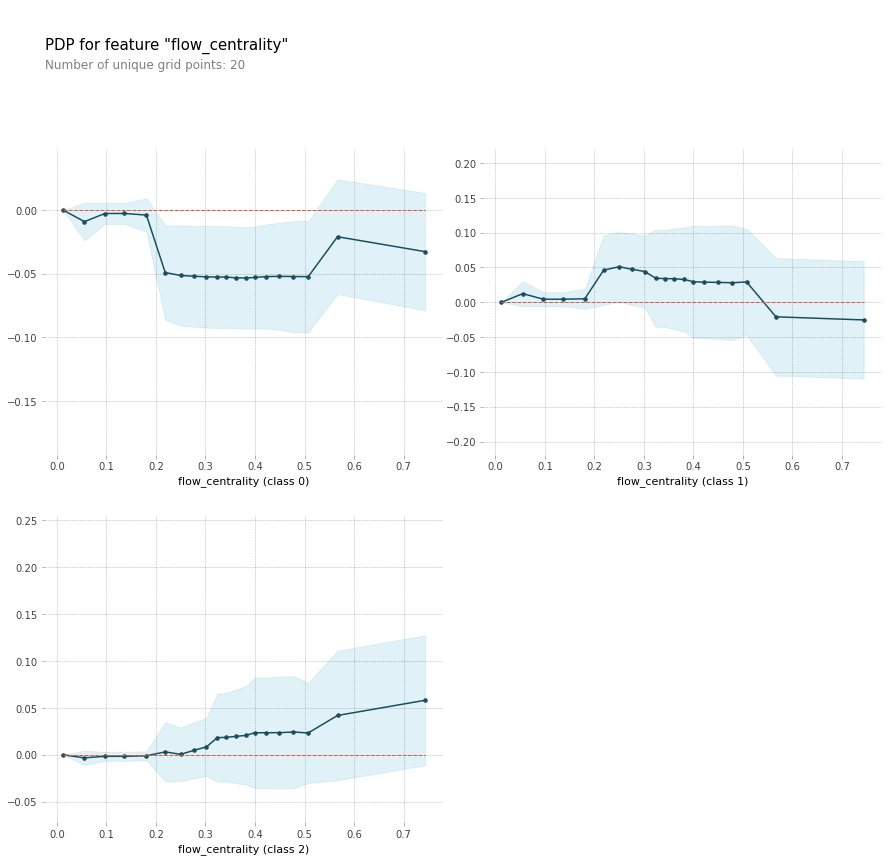

In [111]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'flow_centrality'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name=feature);

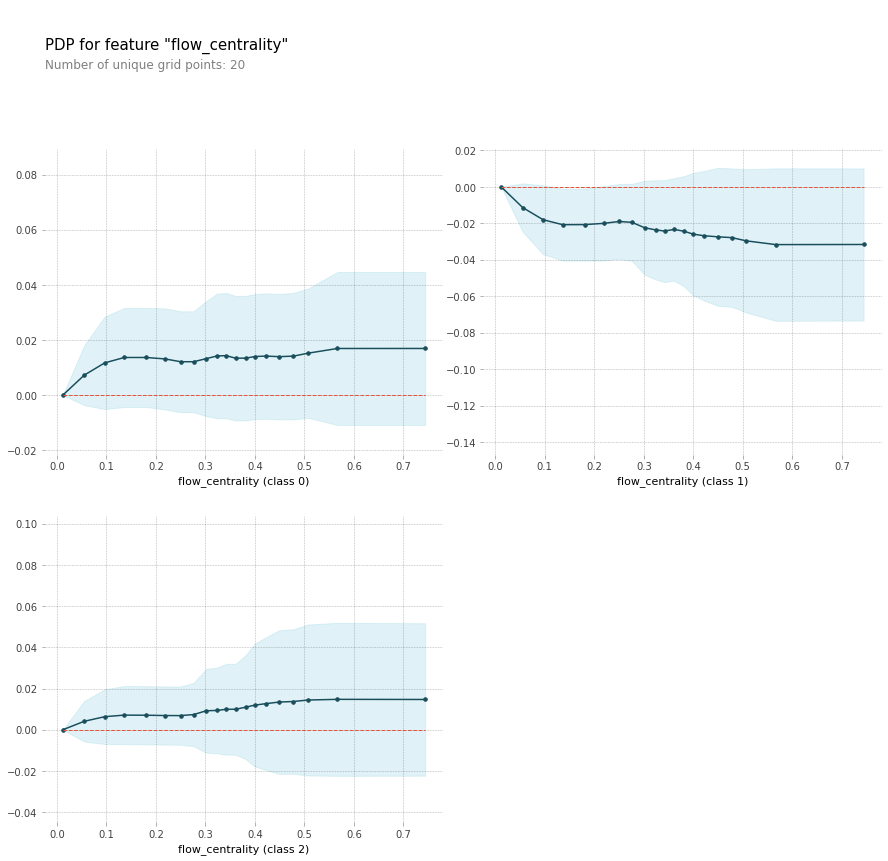

In [112]:
#ai
feature = 'flow_centrality'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name=feature);

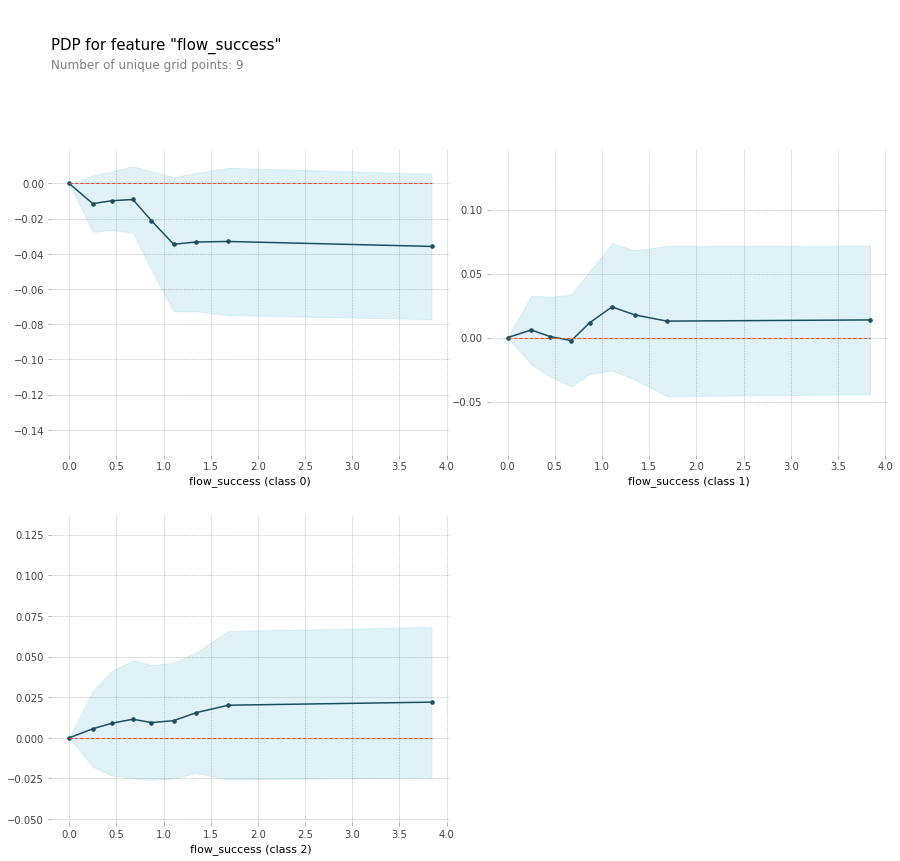

In [113]:
#human
feature = 'flow_success'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

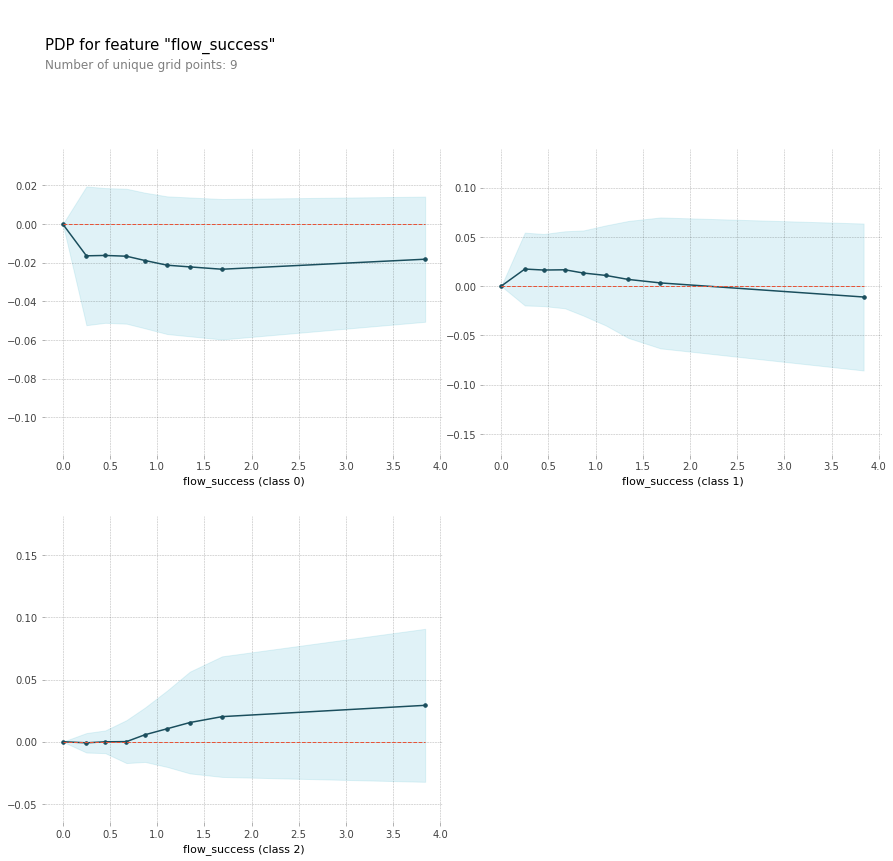

In [114]:
#ai
feature = 'flow_success'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

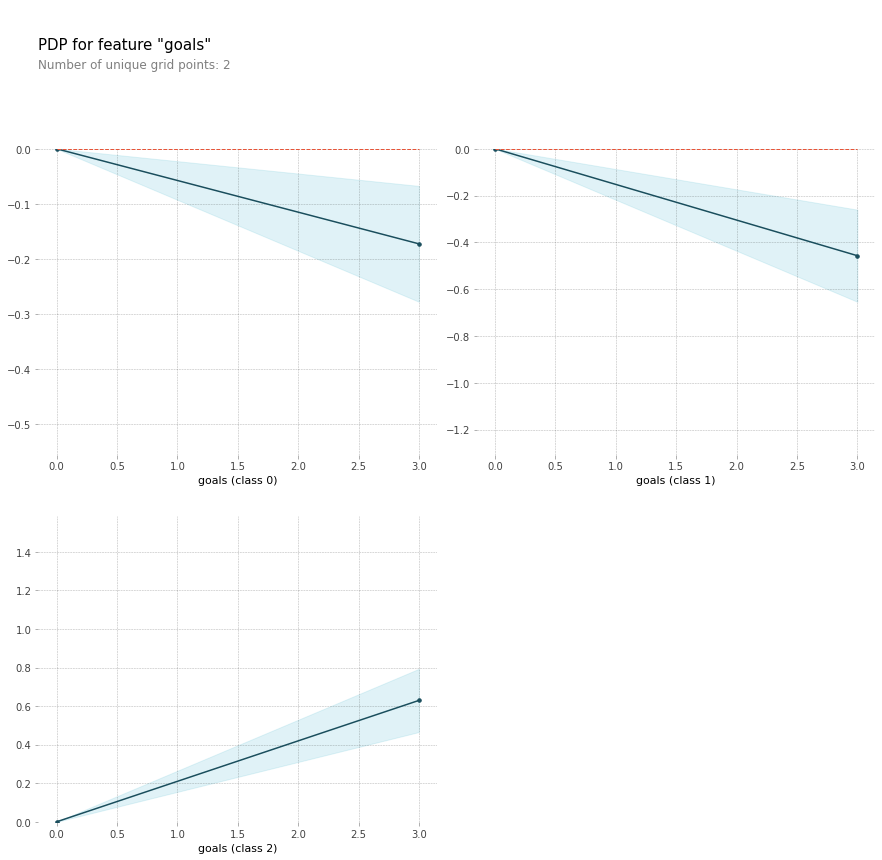

In [115]:
feature = 'goals'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

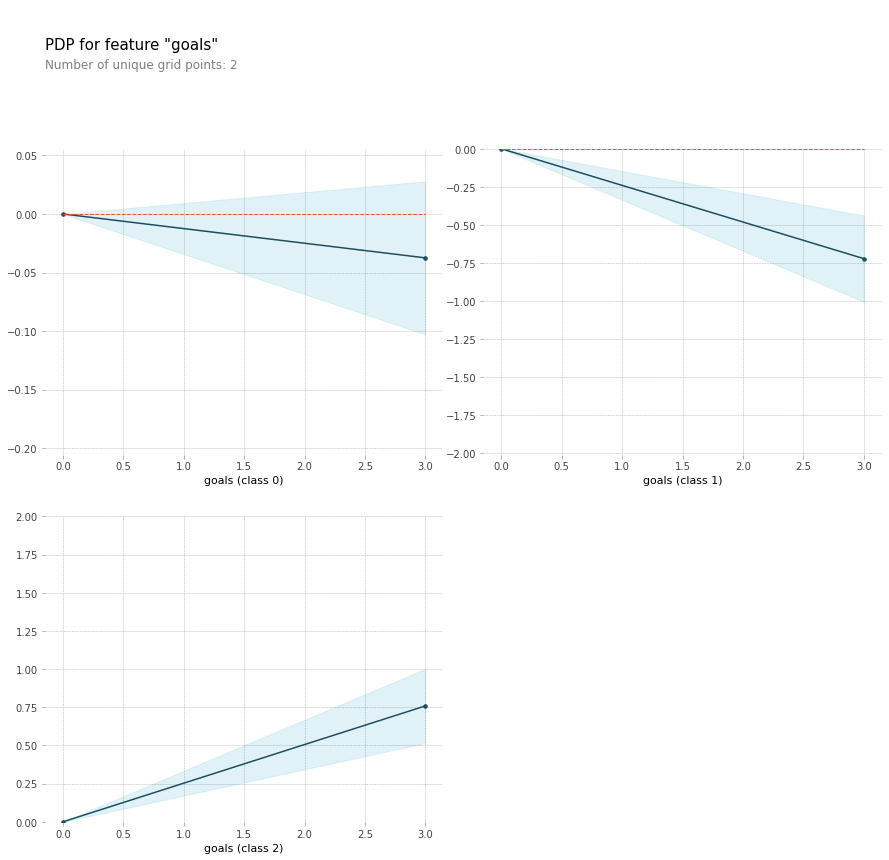

In [116]:
#ai
feature = 'goals'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

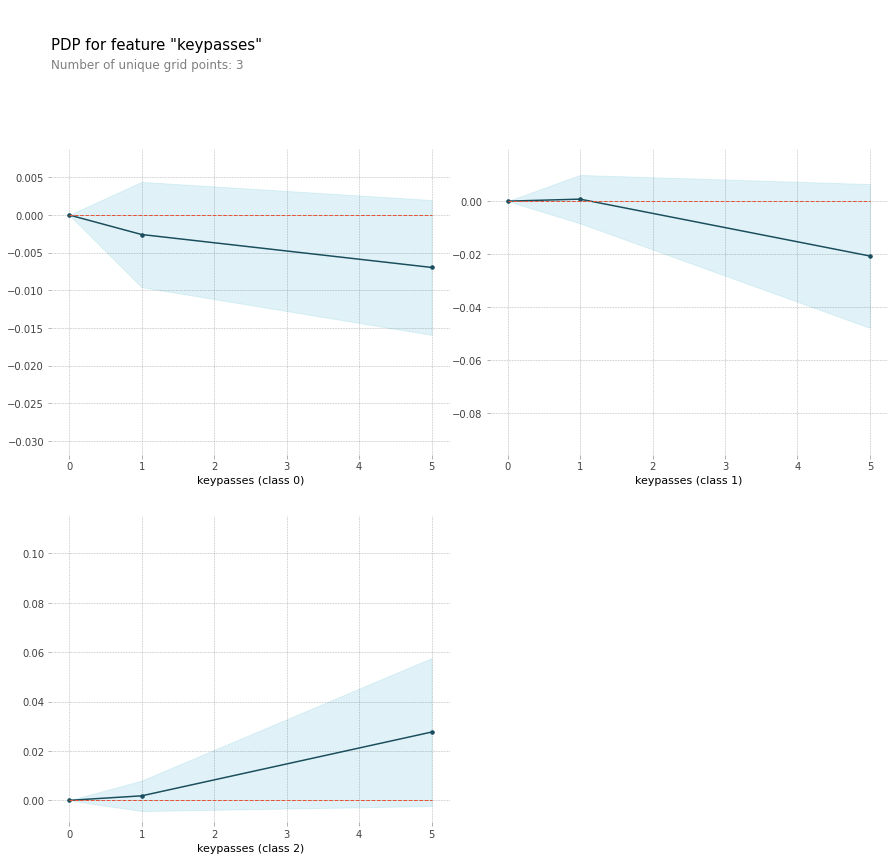

In [117]:
feature = 'keypasses'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

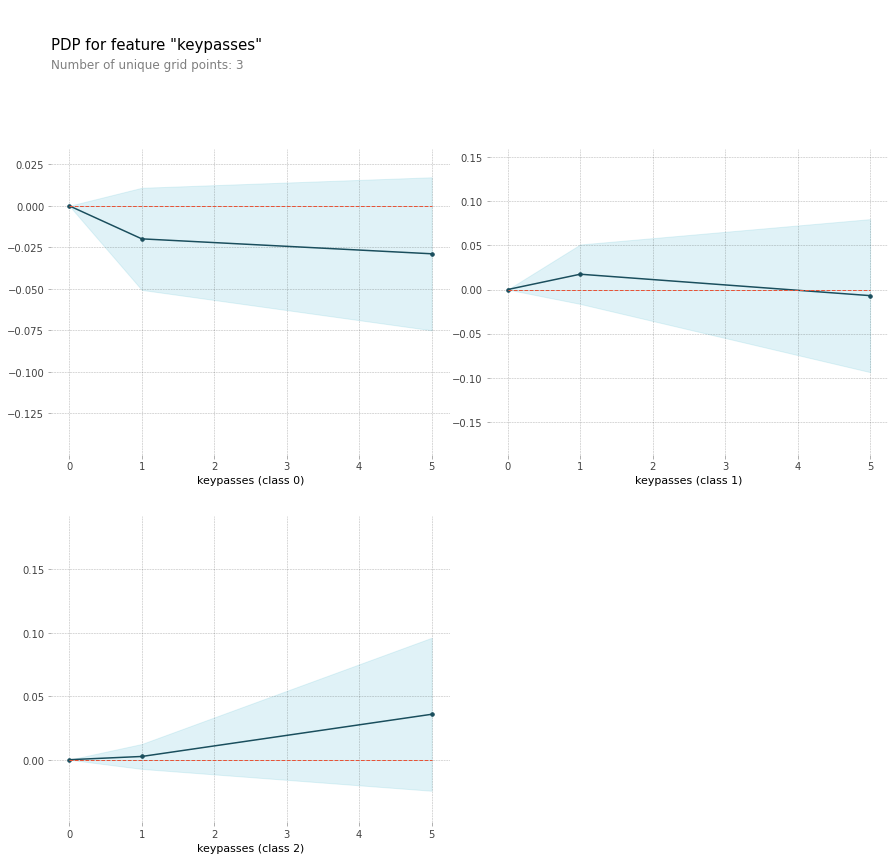

In [118]:
#ai
feature = 'keypasses'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

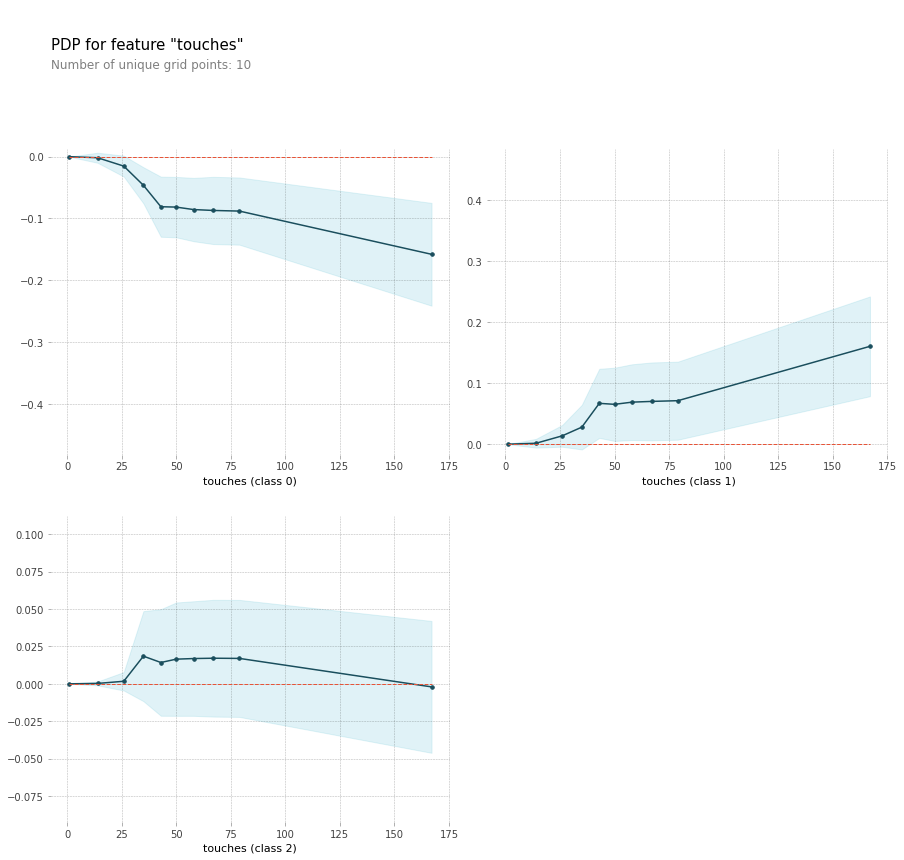

In [119]:
feature = 'touches'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

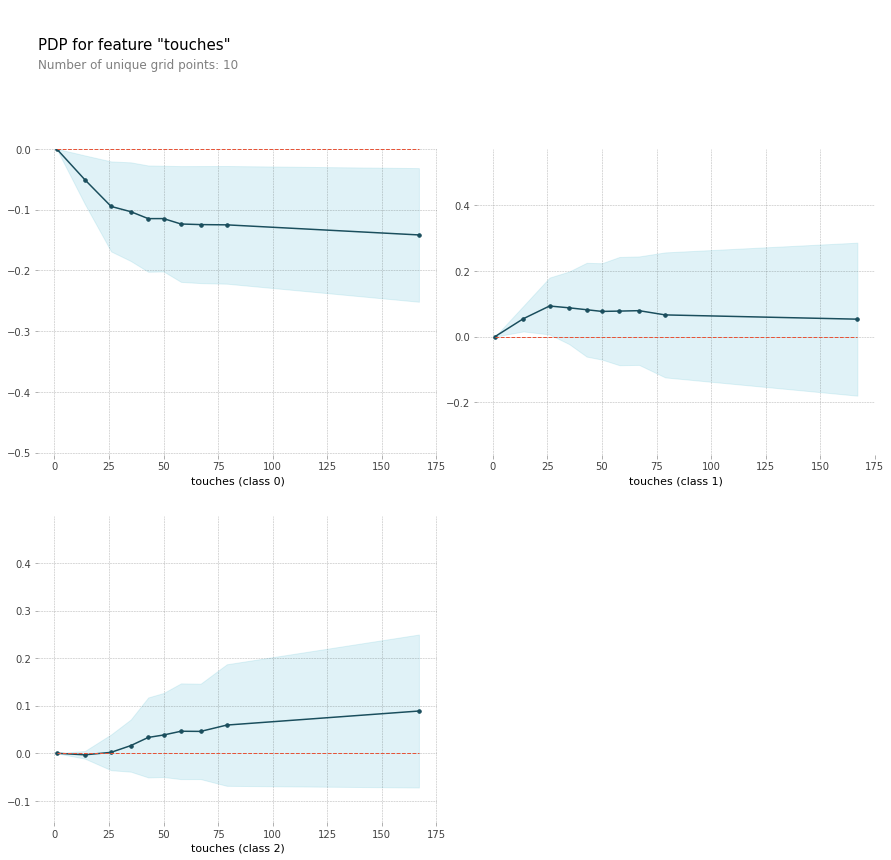

In [120]:
#ai
feature = 'touches'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

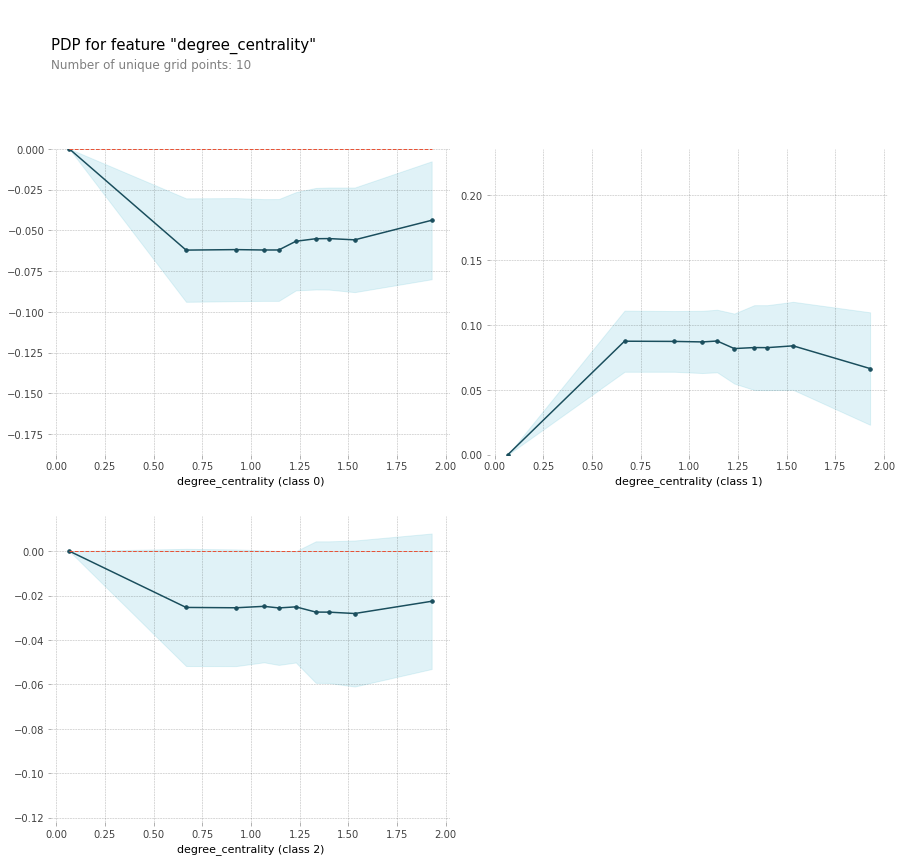

In [121]:
feature = 'degree_centrality'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

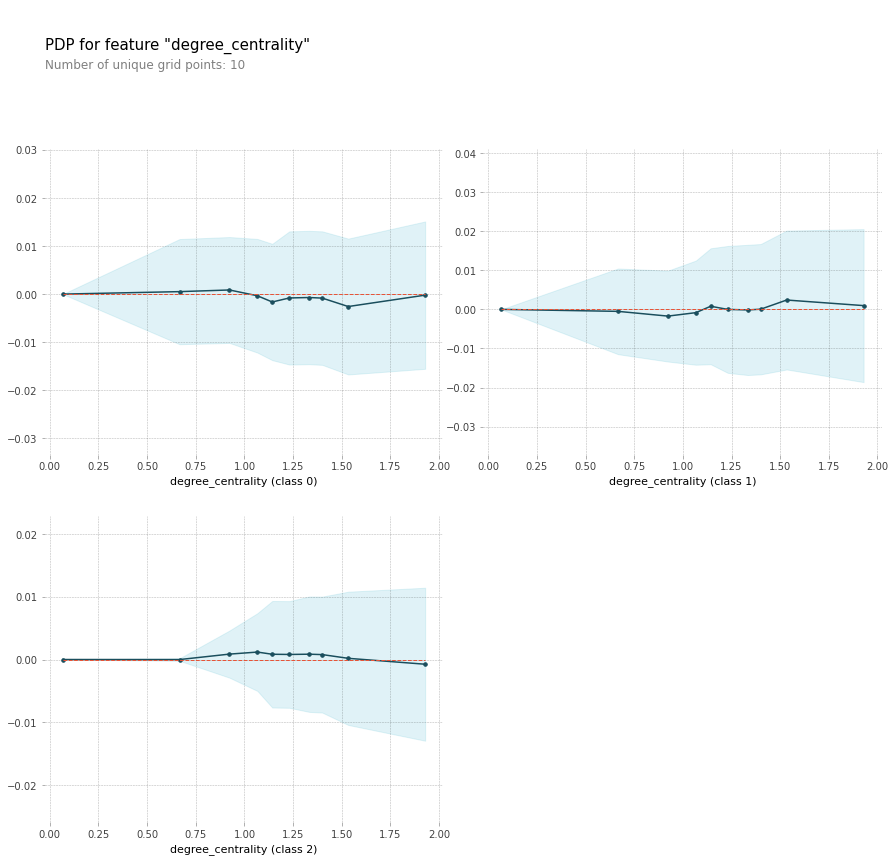

In [122]:
#ai
feature = 'degree_centrality'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

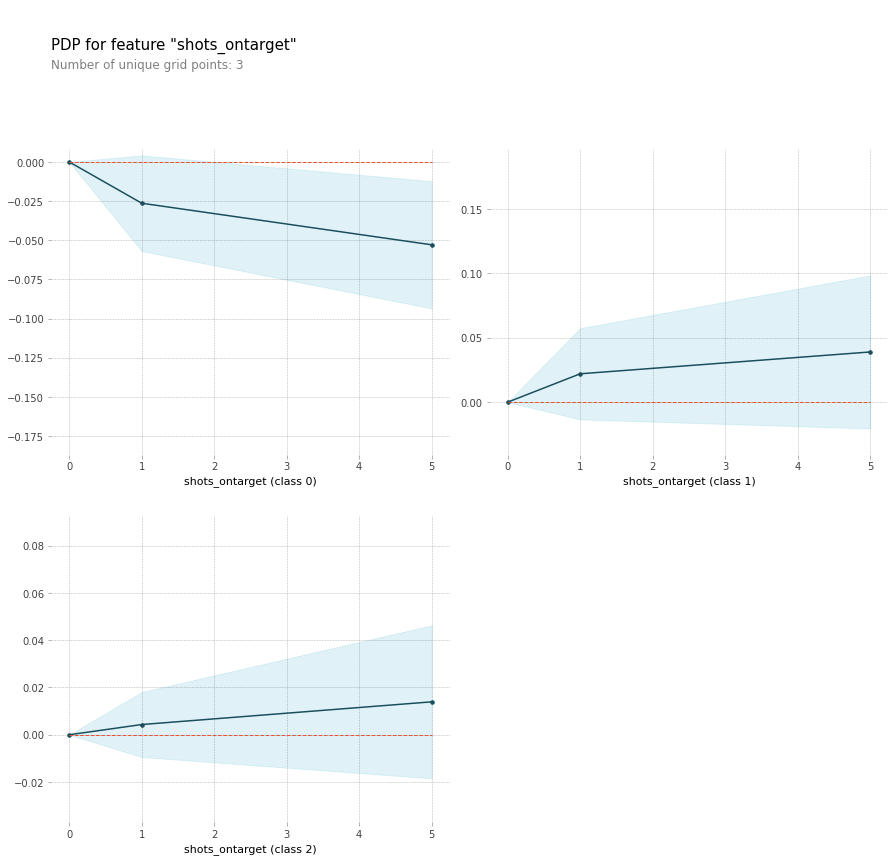

In [123]:
feature = 'shots_ontarget'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

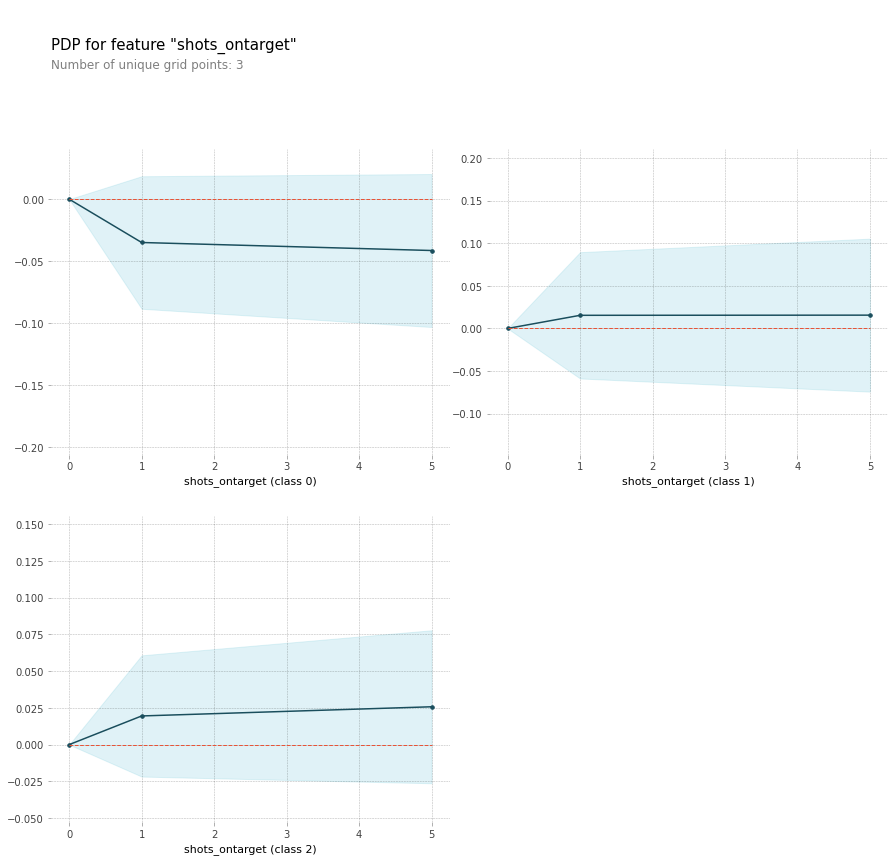

In [124]:
#ai
feature = 'shots_ontarget'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

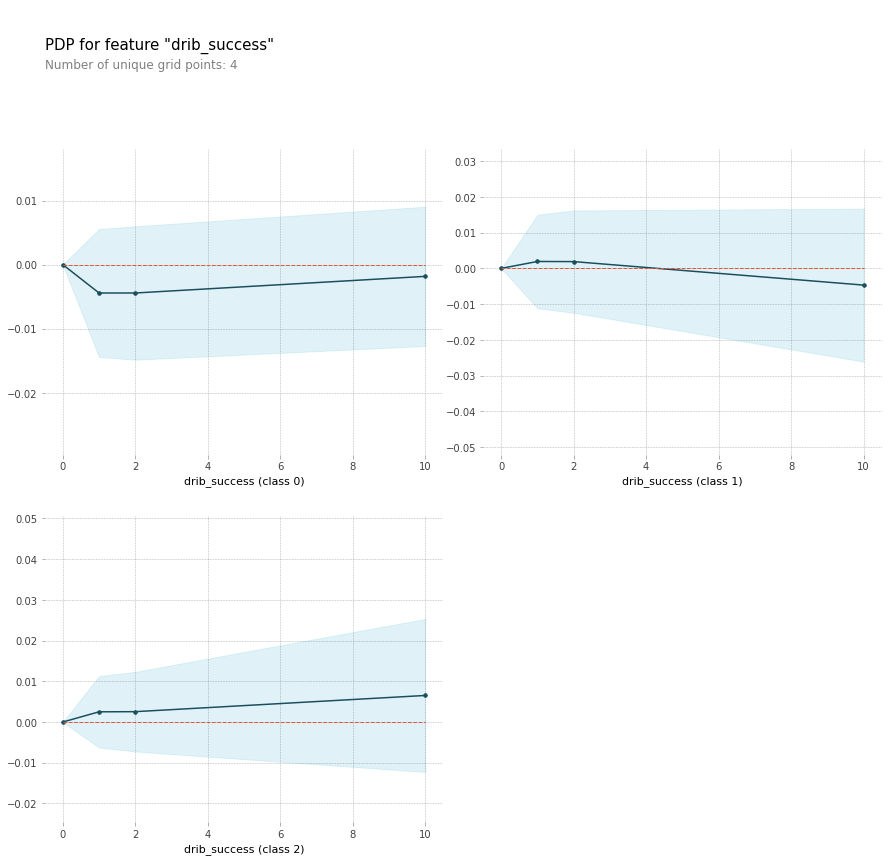

In [166]:
feature = 'drib_success'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

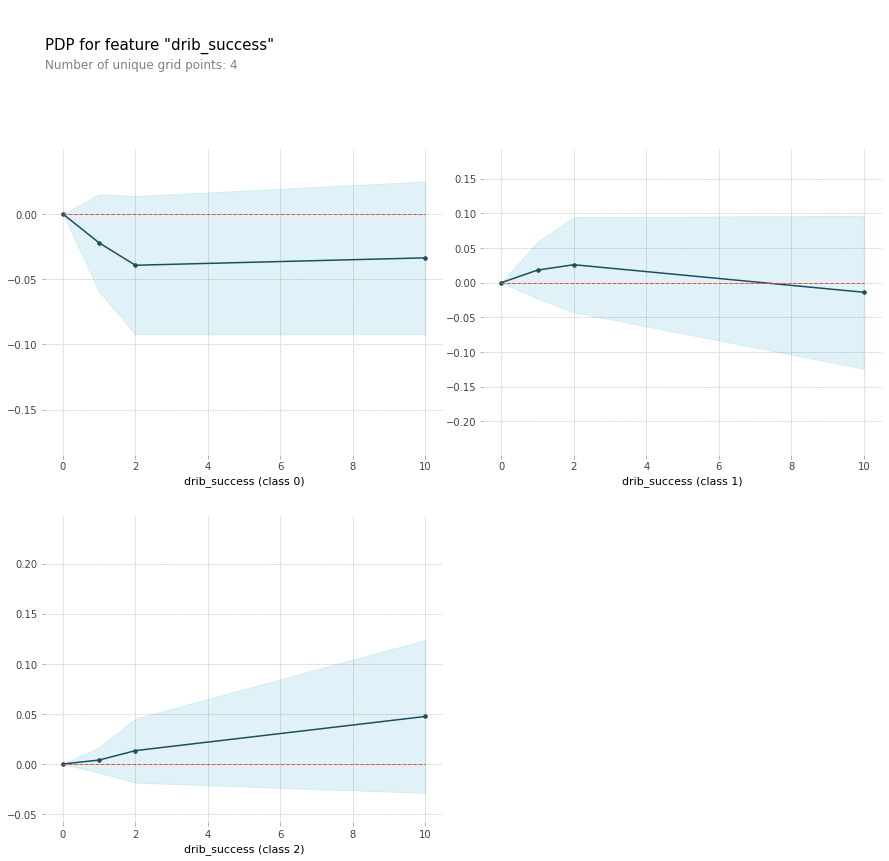

In [167]:
#ai
feature = 'drib_success'

isolated = pdp_isolate(
    model=model_ai, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded_ai.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [46]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [171]:
features = ['flow_centrality', 'touches']

interaction = pdp_interact(
    model=model_ai, 
    dataset=X_test_encoded_ai,
    model_features=X_test_encoded.columns, 
    features=features
)

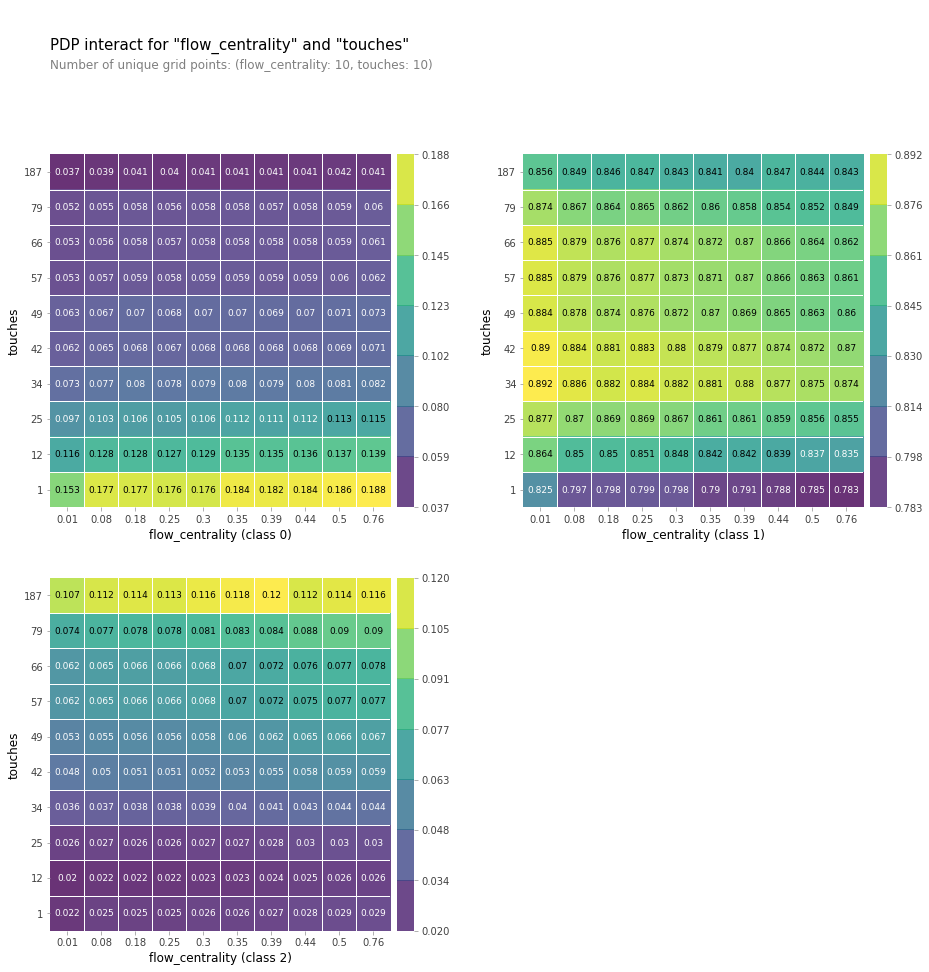

In [172]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

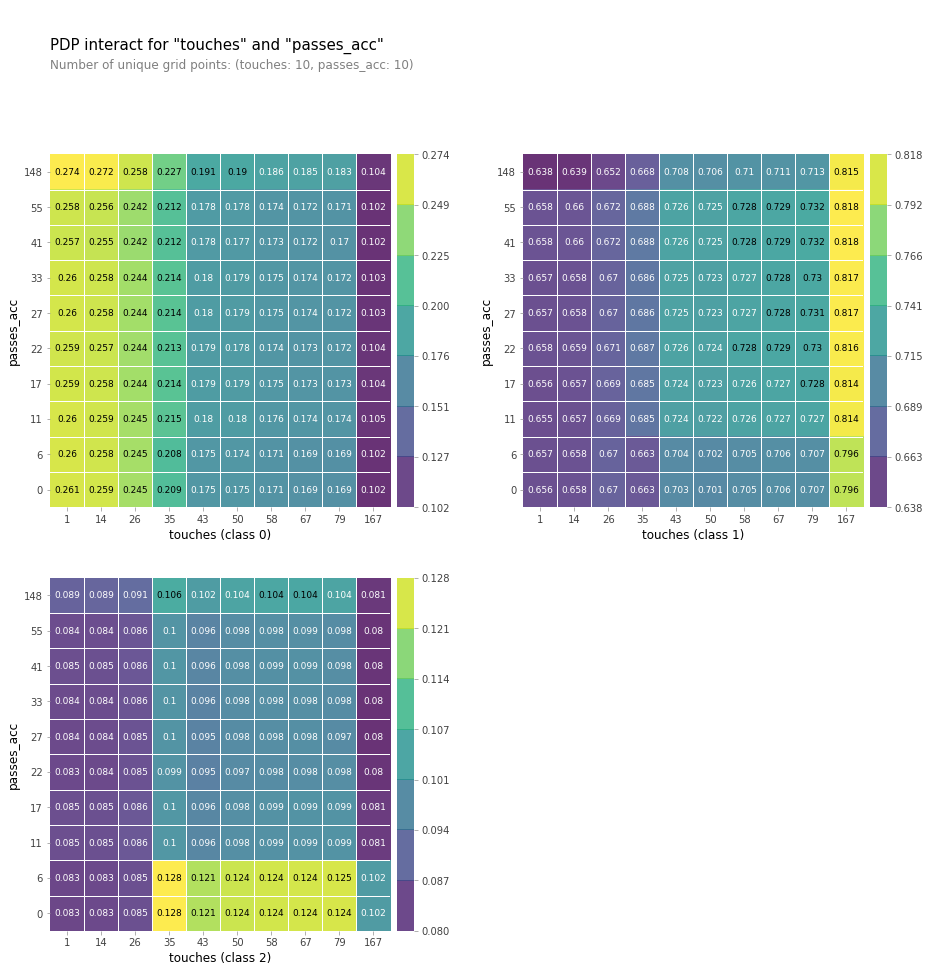

In [169]:
features = ['touches','passes_acc']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_encoded,
    model_features=X_test_encoded.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

# SHAP

In [51]:
row = X_test_encoded.iloc[[1]]
row

,goals,assists,shots_ontarget,shots_offtarget,shotsblocked,chances2score,drib_success,drib_unsuccess,keypasses,touches,...,missed_penalties,owngoals,degree_centrality,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,pass_acc,cross_acc
21202,0,0,0,2,0,2,3,0,0,10,...,0,0,0.266667,0.062994,0.466667,0.04,0.6,0.25,0.0,0.0


In [52]:
y_test.iloc[[1]]

21202    ★★
Name: Grade, dtype: category
Categories (3, object): ['★' < '★★' < '★★★']

In [53]:
model.predict(row)

array(['★★'], dtype=object)

In [54]:
!pip install shap

     |████████████████████████████████| 564 kB 21.8 MB/s 


In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

le.classes_

array(['★', '★★', '★★★'], dtype=object)

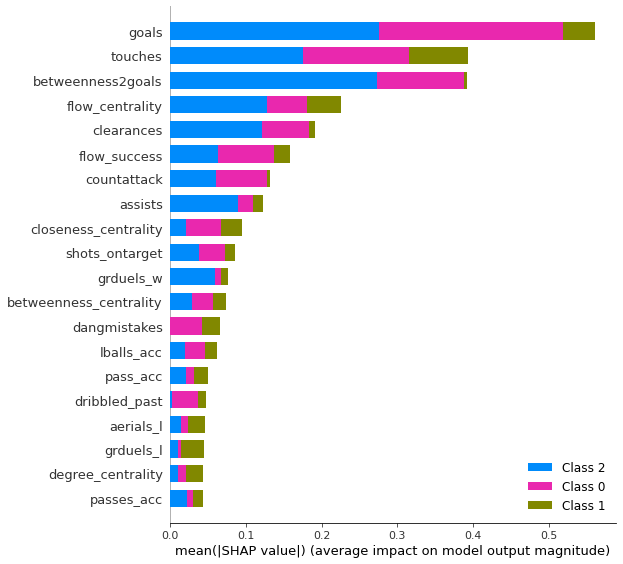

In [173]:
import shap


explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test.iloc[:500])
shap.summary_plot(shap_values, X_test.iloc[:500])

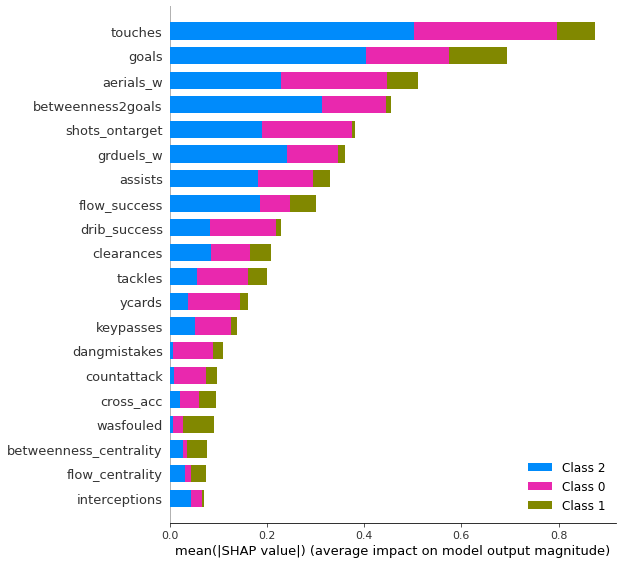

In [174]:
import shap


explainer = shap.TreeExplainer(model_ai)

shap_values = explainer.shap_values(X_test_ai.iloc[:500])
shap.summary_plot(shap_values, X_test_ai.iloc[:500])